### **Deep Belief Network Applied on Fashion-MNST Dataset**
##### Ehsan Eslami Shafigh , ID: 2070769

In this project we will test the capabilities of a **Deep Belief Network (DBN)**, to learn representations of **Fashion MNST** Dataset. We will use those hidden representations for clustering ans classification tasks. Also we will test the robustness of the network agianst regular and adversarial noises. We will also check if the reconstruction of input data using the top-down approach can help to increase the classification accuracy.

Let's begin by downloading some scripts in order to implement a deep belief network using PyTorch.

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
from tqdm.notebook import tqdm
import torch.nn.functional as functional
from sklearn.metrics import confusion_matrix
import seaborn as sns

from DBN import DBN

Now we set the processing unit to GPU

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


Next we download the Fashion-MNST dataset.

In [5]:
%%capture
fmnst_tr = tv.datasets.FashionMNIST(root="../fmnst", train=True, download=True)
fmnst_te = tv.datasets.FashionMNIST(root="../fmnst", train=False, download=True)

 We normalize the values between 0 and 1.

In [6]:
fmnst_tr.data = fmnst_tr.data / 255
fmnst_te.data = fmnst_te.data / 255

Next we upload the dataset into the GPU

In [7]:
fmnst_tr.data = fmnst_tr.data.to(device)
fmnst_te.data = fmnst_te.data.to(device)
fmnst_tr.targets = fmnst_tr.targets.to(device)
fmnst_te.targets = fmnst_te.targets.to(device)

Let's visualize a sample from the dataset.

The image shows the digit: 2


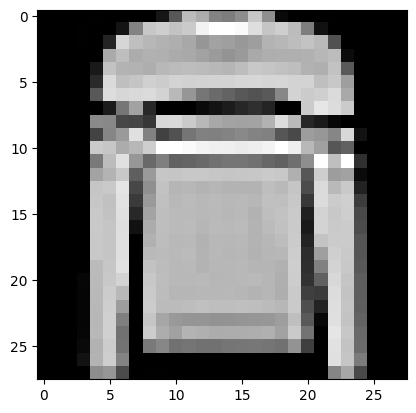

In [8]:
idx = 5
img = fmnst_tr.data[idx].cpu()  # to plot the data, we need to move it back from the GPU memory
print("The image shows the digit: {}".format(fmnst_tr.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

#### **Model Archtecture**

Let's quickly review what a deep belief network is:

*   Deep Belief Networks (DBNs) are a type of hierarchical generative model constructed from a series of Restricted Boltzmann Machines (RBMs), which are a category of unsupervised graphical models.
*   The learning process for DBNs is unsupervised, aiming to understand the probability distribution that could have produced the training data (maximum-likelihood).
*   DBNs can analyze input data through a forward (bottom-up) pass to compute hidden representations of the sensory input, a process known as "inference" over latent variables.
*   Additionally, DBNs can generate plausible sensory input through a backward (top-down) pass, which can be utilized to create class prototypes.
*   The training of DBNs involves an algorithm called "contrastive divergence," which seeks to minimize the distinction between the learned probability distribution and the true (empirical) distribution.














We start by defining the model as follows:

In [9]:
dbn_fmnst = DBN(visible_units=28*28,          # dimensionality of the sensory data
                hidden_units=[200, 250, 400 ], # size of hidden layers
                k=1,                          # reconstruction steps in Contrastive Divergence
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

The input (visible) layer has the same dimensionality as the input images. We have three layers of hidden units. We will have only 1 contrastive divergence cycle during training.

Let's start training the model:

In [10]:
num_epochs = 50
batch_size = 125

dbn_fmnst.train_static(
    fmnst_tr.data,
    fmnst_tr.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.0306     |0.0921       |235.2990   |6.2193     |
|20    |1.9264     |0.0893       |215.9693   |4.9676     |
|30    |1.8840     |0.0875       |208.3660   |4.0455     |
|40    |1.8696     |0.0864       |205.5070   |4.0559     |
|50    |1.8655     |0.0860       |206.0143   |5.1536     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7427     |0.0654       |68.5434   |1.7879     |
|20    |1.6323     |0.0567       |64.0879   |1.5851     |
|30    |1.6073     |0.0575       |62.6201   |1.4364     |
|40    |1.5953     |0.0570       |62.3284   |1.4725     |
|50    |1.5820     |0.0568       |61.3761   |1.6524     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3459     |0.0445       |84.0445   |1.7249     |
|20    |1.1748     |0.0418       |71.9383   |1.4991     |

The reconstruction error, is simply the Euclidian distance between the original and the reconstructed images. Note that, we are using static training, which means while training the model parameters at each layer, we freeze the parameters from the rest of the layers, and then we move to the next layer.

#### **Receptive Fields Visualization**

Following the training phase, we can depict the "receptive fields" of each hidden neuron by graphing the learned weights associated with them. This visualization enables an examination of the image regions that activate the unit corresponding to a particular weight vector.

Applying a threshold to the learned weights can be beneficial to mitigate noise in the plots. Additionally, as the values in various weights may have disparate ranges, we employ a MinMaxScaler from Scikit-Learn to ensure a meaningful comparison across the visualizations of different receptive fields.

First we define some useful functions:

In [11]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

Let's see how the weights entering the first layer look like. Here we visualize 100 sample of them.

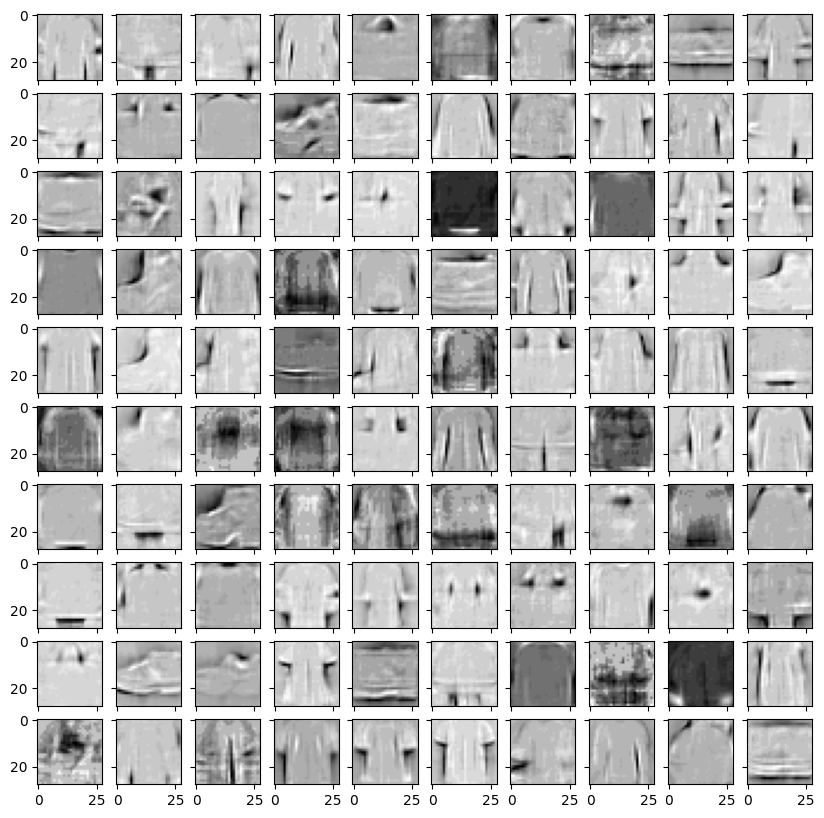

In [12]:
w1 = get_weights(dbn_fmnst, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

The receptive fields from the first layer look like some edges and corners from the objects in the dataset. They represent simple features.

The weights in between first and second, second and third layer need to be projected to 28 by 28 dimension, as their dimensionality is different. Let's see the projected weights from layer 2:

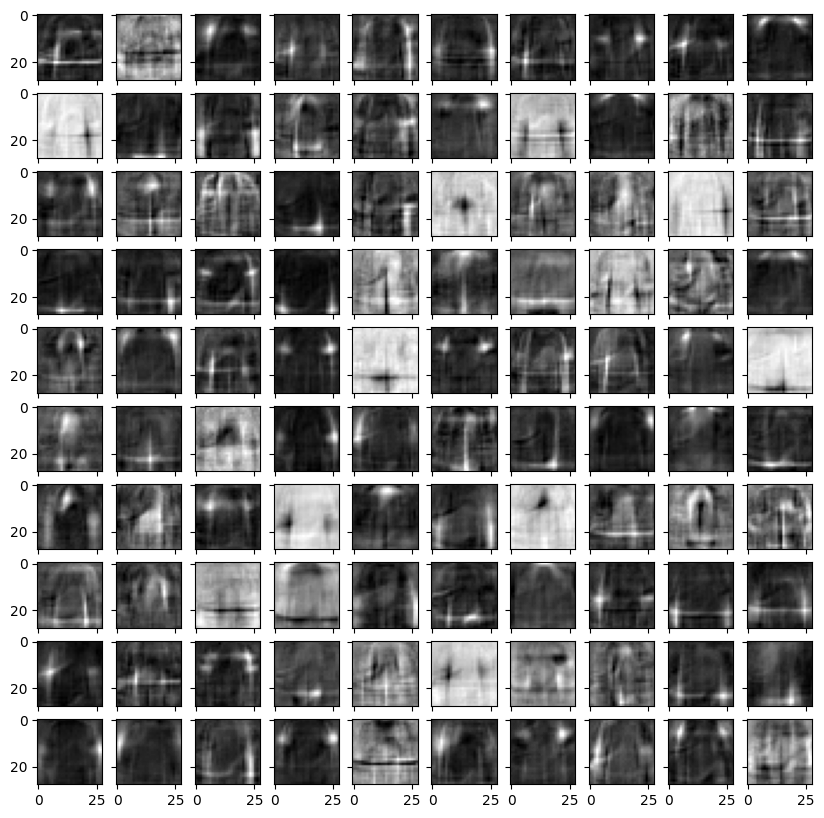

In [13]:
w1 = get_weights(dbn_fmnst, layer=0)
w2 = get_weights(dbn_fmnst, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

Now the projected weights from the third layer:

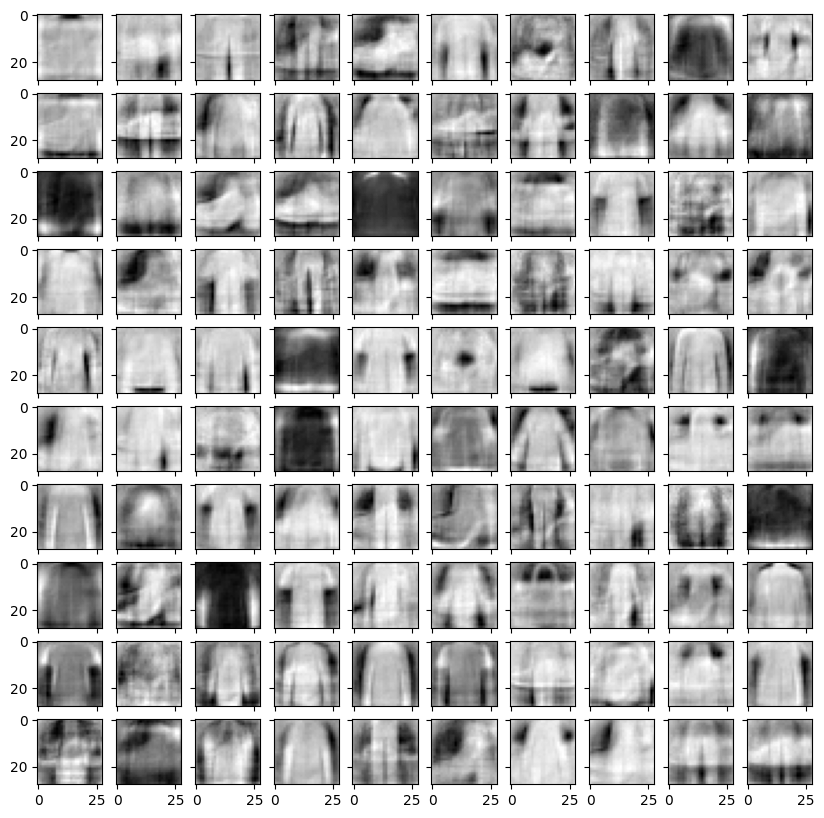

In [14]:
w1 = get_weights(dbn_fmnst, layer=0)
w2 = get_weights(dbn_fmnst, layer=1)
w3 = get_weights(dbn_fmnst, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

As we climb the hierarchy, the weights represent more complex features such that the weights from the third layer look almost like the objects themselves.

#### **Clustering The Internal Representations**

In this section, We deal with the hidden layers of the network. For each class in the dataset, we will find the centroid of the third layer representation of the objects belonging to that class. In this way we can perform a hirerarchical clustering, to see which classes are closer to each other.

First we need to extract the hidden representation corresponding to each layer. We define a function for this purpose:

In [15]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fmnst.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

We can compute the hidden representation belonging to each layer, using the hidden representation from the previous layer:

In [16]:
hidden_repr_1 = get_kth_layer_repr(fmnst_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)

torch.Size([60000, 200])


Finally, we need to define some functions to calculate the centroid of the hidden representations for each class in the dataset.

In [17]:
def get_mask(label):  # we use this function to filter by class
  labels = fmnst_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [18]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

In [19]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

Now we can run the clustering algorithm and visualize it in a dendrogram plot.

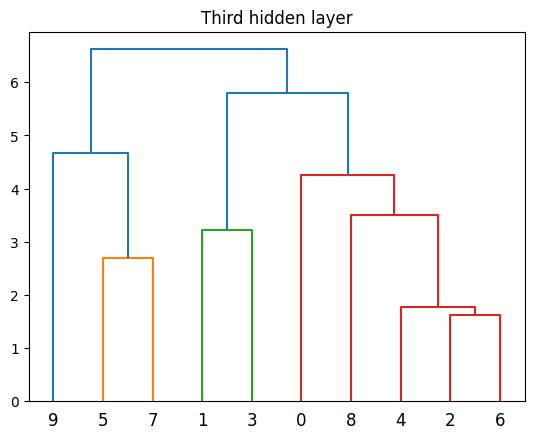

In [20]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

To be able to understand the above diagram, let' see what each digit lable represent in the Fashion MNST dataset:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

As we see the digram makes sense. For example, the sneakers and sandal are quite similar to each other and in the digram they are neighbours as expected.

#### **Linear Read-Out**

Another way to exploit the hidden representations is to decode them with a linear classifer.  We start by defining a class for the linear classifier.

In [21]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

Next we instantiate a linear classifier for each layer of the DBM.

In [22]:
layer_size = dbn_fmnst.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fmnst.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fmnst.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Now let's train the classifiers at each layer using the true labels from the Fashion MNST dataset.

In [23]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1000

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = fmnst_tr.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [24]:
train_linear(linear1, hidden_repr_1)

epoch :   1/1000, loss = 2.3453
epoch : 101/1000, loss = 0.9806
epoch : 201/1000, loss = 0.7625
epoch : 301/1000, loss = 0.6761
epoch : 401/1000, loss = 0.6276
epoch : 501/1000, loss = 0.5953
epoch : 601/1000, loss = 0.5718
epoch : 701/1000, loss = 0.5536
epoch : 801/1000, loss = 0.5389
epoch : 901/1000, loss = 0.5269


In [25]:
train_linear(linear2, hidden_repr_2)

epoch :   1/1000, loss = 2.2822
epoch : 101/1000, loss = 0.8232
epoch : 201/1000, loss = 0.6745
epoch : 301/1000, loss = 0.6128
epoch : 401/1000, loss = 0.5762
epoch : 501/1000, loss = 0.5509
epoch : 601/1000, loss = 0.5322
epoch : 701/1000, loss = 0.5175
epoch : 801/1000, loss = 0.5056
epoch : 901/1000, loss = 0.4958


In [26]:
train_linear(linear3, hidden_repr_3)

epoch :   1/1000, loss = 2.2929
epoch : 101/1000, loss = 0.8894
epoch : 201/1000, loss = 0.7061
epoch : 301/1000, loss = 0.6330
epoch : 401/1000, loss = 0.5910
epoch : 501/1000, loss = 0.5628
epoch : 601/1000, loss = 0.5421
epoch : 701/1000, loss = 0.5260
epoch : 801/1000, loss = 0.5131
epoch : 901/1000, loss = 0.5025


Now we can evaluate the performance of each classifer on the test data:

In [27]:
hidden_repr_1_test = get_kth_layer_repr(fmnst_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [28]:
# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

Now we can determine the accuracies:

In [29]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [30]:
compute_accuracy(predictions_test1, fmnst_te.targets)

0.8133999705314636

In [31]:
compute_accuracy(predictions_test2, fmnst_te.targets)

0.821399986743927

In [32]:
compute_accuracy(predictions_test3, fmnst_te.targets)

0.8206999897956848

The accuracies are almost the same for all layers. We can also create a confusion matrix for each classifier at each layer:

In [33]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Here we convert the predictions to class labels.

In [34]:
predicted_labels1 = predictions_test1.argmax(dim=1).cpu().numpy()
predicted_labels2 = predictions_test2.argmax(dim=1).cpu().numpy()
predicted_labels3 = predictions_test3.argmax(dim=1).cpu().numpy()

In [35]:
true_labels = fmnst_te.targets.cpu().numpy()

# Define class names (assuming 0 to 9 for Fashion MNIST classes)
class_names = [str(i) for i in range(10)]

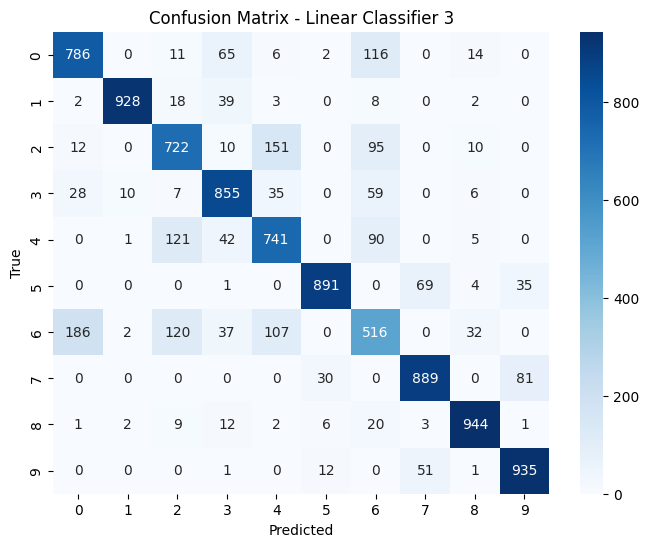

In [36]:
plot_confusion_matrix(true_labels, predicted_labels3, class_names, title="Confusion Matrix - Linear Classifier 3")

The class 6 is the most confused class. Incidently in the dendrogram class 6, 4 , 2 and are the closest clusters to each other, which are also most confused as shown in the confusion matrix.  

#### **Comparison with a Feed-Forward Neural Network**

In this section we want to compare the performance of the DBN with a FFNN of the same complexity size.

In [37]:
def train_supervised(network, input_data, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input_data).squeeze()
    targets = fmnst_tr.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [38]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [39]:
ffnn = Feedforward(200, 250, 400).to(device)

In [40]:
train_supervised(ffnn, fmnst_tr.data.reshape((60000, 784)), 1050)

epoch :   1/1050, loss = 2.3028
epoch : 101/1050, loss = 1.6396
epoch : 201/1050, loss = 0.9110
epoch : 301/1050, loss = 0.7946
epoch : 401/1050, loss = 0.7034
epoch : 501/1050, loss = 0.6435
epoch : 601/1050, loss = 0.5995
epoch : 701/1050, loss = 0.5647
epoch : 801/1050, loss = 0.5386
epoch : 901/1050, loss = 0.5182
epoch : 1001/1050, loss = 0.4952


In [41]:
predictions_ffnn = ffnn(fmnst_te.data.reshape((10000, 784)))

In [42]:
compute_accuracy(predictions_ffnn, fmnst_te.targets)

0.8118000030517578

So, the performance of the DBN and the FFNN are almsot the same.

#### **Robustness to Noise**

In the previous section we observed that the performance of the DBN to a FFNN of the same complexity, is almost equal. Now we can test their robustness to some noise on the data. We will add noise to the dataset, and see if the models are still able to classify the objects correctly.

Specifically, we are interested in a psychometric curve

Let's define a function using which we can add noise to the dataset.

In [43]:
def inject_noise(mnist_data, noise_level):
    device = mnist_data.device
    noise = noise_level * torch.randn(mnist_data.shape, device=device)
    noisy_mnist_data = mnist_data + noise
    return noisy_mnist_data

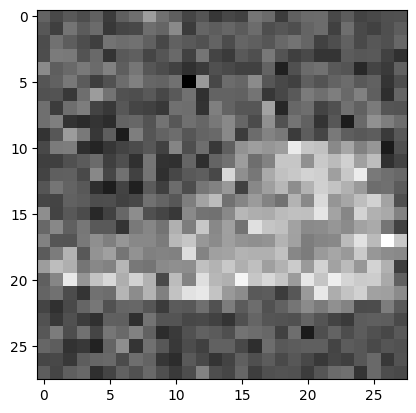

In [44]:
noise_level = 0.2
fmnst_test_with_noise = inject_noise(fmnst_te.data, noise_level)
__ = plt.imshow(fmnst_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

Now we use the same kind of linear classifiers we used previously, but this time after applying a specific value of noise. Then we get the accuracies at that noise level:

In [45]:
def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(fmnst_te.data, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)


  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, fmnst_te.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, fmnst_te.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, fmnst_te.targets)


  predictions_ffnn = ffnn(mnist_test_with_noise.reshape((10000, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn, fmnst_te.targets)


  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [46]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.784
Accuracy of H2 read-out: 0.805
Accuracy of H3 read-out: 0.806
Accuracy of FF network : 0.779


Using the accuracies, we can create a psychometric curve. We will see how the models perform as we increase the noise level.

In [47]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

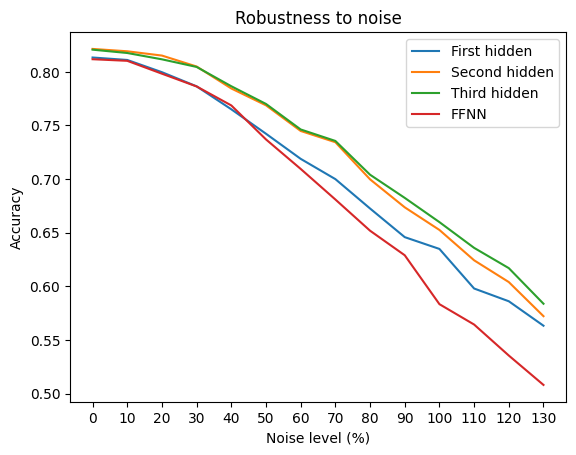

In [48]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

As you see, in most noise levels, the third hidden layer hase the highest accuracy. On the other hand, the FFNN has the lowest accuracy. Therefore we can conclude that the higher we go in the layers of the DBN, the higher the robustness of the model is against noise.

#### **Adversarial Attacks**

To have an adversarial attack on the model, the approach is to modify the input such that the model cannot classify it correctly anymore.

A poosible way to do this, is to change the input in the direction of the gradient of the loss function. This requries knowing the correct label of the input so that we can compute the loss function.

In mathematical terms, if $ x $ represents the input data and $ \tilde{x} $ is the modified input, and $J(w, x, y)$ is the loss function, we want to change $ x $ as follows:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

Let's create adversial samples for both the DBM and feedforward network and compare their resistence to the attack.

First we need to have a function which adds a noise of the type we defined above:

In [49]:
def fgsm_attack(image, epsilon, data_grad):

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    perturbed_image = image + sign_data_grad * epsilon

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

The above function need the gradient as an input, therfore we need to define an archtucture to evaluate the gradients:

In [50]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [51]:
dbn_with_readout = DBNWithReadOut(dbn_fmnst, [linear1, linear2, linear3], readout_level=2)

Now let's see how the adversial samples look like.

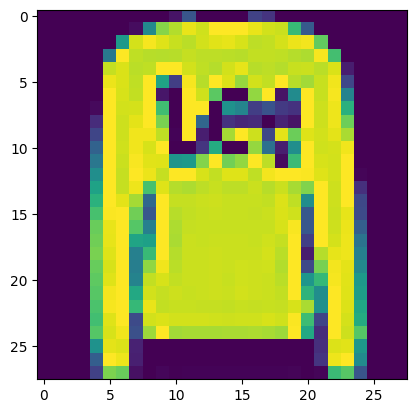

In [52]:
test_sample_idx = 1
test_image = fmnst_te.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

This is a "clean" sample from the test data. Now let's first classify it:

In [57]:
attacked_model = dbn_with_readout
#attacked_model = ffnn

In [58]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 2.


The prediction of the model is correct. Now let's create the adversarial sample:

In [59]:
epsilon = 0.3  # define strenght of the attack
test_image_label = fmnst_te.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

In [60]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 8.


So as you see the attack resulted in the wrong classification of the test sample.

Now let's check if we can exploit the reconstruction ability of the DBNs. We can reconstruct the modified sample using the top-bottom approach of DBNs. And then classify the sample again, this way we can possibly tackle the adverarial attack.

The below function tests the accuracy of the models after the adversarial noise is applied on the input test data. If requested, it performs a reconstruction of the input as well:

In [61]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, print the result

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [62]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST(root="../fmnst", train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

Let's see the FFNN performance:

In [63]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 2.58%



How about the DBN?

In [64]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 17.21%



Now let's see if the reconstruction helps?

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



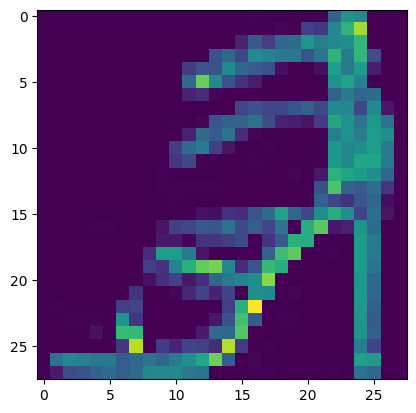


Here's a perturbed sample:



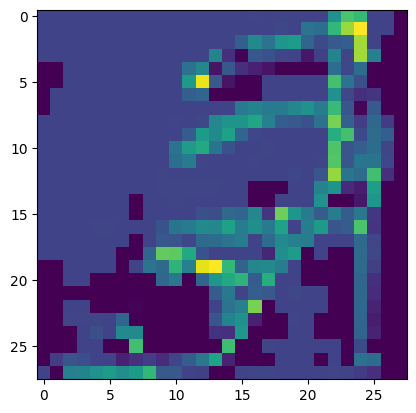


Here's what a 1-steps reconstructed sample looks like:



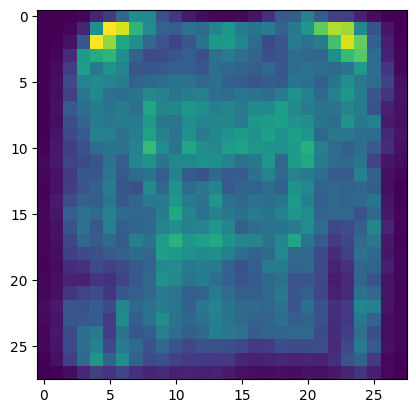


Epsilon: 0.2
Test Accuracy: 16.32%



In [65]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=1)

The reconstruction does not lead to a better accuracy in this case.

Finally let's see the robustness of each model to different noise amplitudes:

In [66]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [67]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

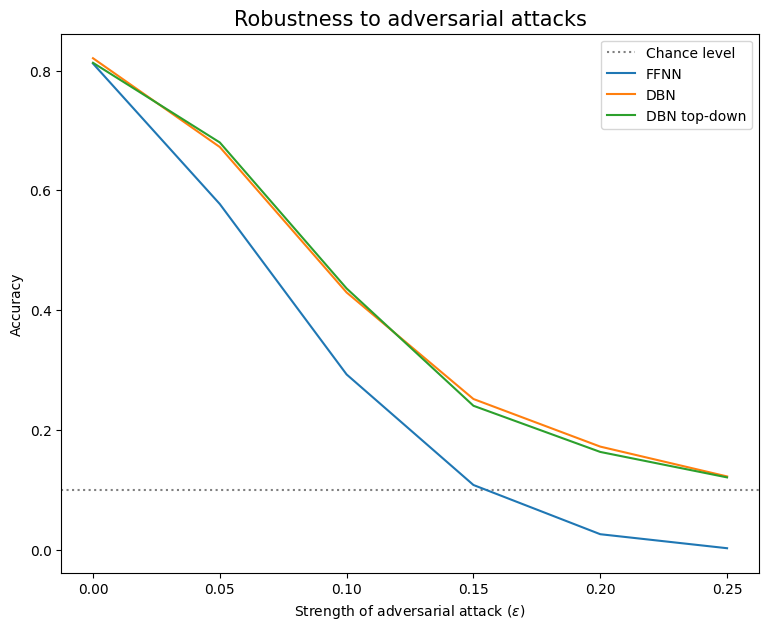

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

The above curve shows that even though the robustness of the DBN is higher than FFNN in all noise levels, but unlike what we expectd, 1-step reconstruction of the data did not improve the accuracies much. (or even decreased at some noise levels)